In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFRegressor, XGBRegressor
import catboost as ctb
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("Train_Data.csv")
test=pd.read_csv("Test_Data.csv")

In [3]:
# df1.shape

NameError: name 'df1' is not defined

In [167]:
# fig, axes = plt.subplots(4, 4, figsize=(25, 20))
# for i,ax in zip(range(df1.shape[1]),axes.flat):
#     probplot(((df1[:,i])),dist='norm',plot=ax)
#     probplot(((df.iloc[:,i])),dist='norm',plot=ax)
#     ax.set_title(i)
# plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [4]:
le = LabelEncoder()
# lb = LabelBinarizer()
df['adgroup'] = le.fit_transform(df['adgroup'])
test['adgroup']=le.transform(test['adgroup'])
# df = df.join(pd.DataFrame(lb.fit_transform(df['adgroup'])))
# test = test.join(pd.DataFrame(lb.transform(test['adgroup'])))
# df.drop(['adgroup'],axis=1)
# test.drop(['adgroup'],axis=1)
df = df.set_index(df['date'])
test = test.set_index(test['date'])

df["impressions"] = np.log(df["impressions"])
df["clicks"] = np.log(df["clicks"])
df["cost"] = np.log(df["cost"])

test["impressions"] = np.log(test["impressions"])
test["clicks"] = np.log(test["clicks"])
test["cost"] = np.log(test["cost"])

df.drop(['date', 'campaign'],axis=1,inplace=True)
test.drop(['date','campaign'],axis=1,inplace=True)


/home/akhil/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
for i in range(len(df)):
    df['ad'][i] = int(df['ad'][i][3:])
for i in range(len(test)):
    test['ad'][i]=int(test['ad'][i][3:])
df['ad']=pd.to_numeric(df['ad'])
test['ad']=pd.to_numeric(test['ad'])
df.drop(['ad'],axis=1,inplace=True)

/tmp/ipykernel_69646/2739739156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ad'][i] = int(df['ad'][i][3:])
/tmp/ipykernel_69646/2739739156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ad'][i]=int(test['ad'][i][3:])


In [6]:
# sns.pairplot(df,hue="revenue")

In [7]:
df['CTR']=df['clicks']/df['impressions']
df['CPC']=df['cost']/df['clicks']
df['CPA']=df['cost']/df['conversions']

test['CTR']=test['clicks']/test['impressions']
test['CPC']=test['cost']/test['clicks']
test['CPA']=test['cost']/test['conversions']

df['CPC'].fillna(df.CPC.interpolate(),inplace=True)
df['CPA'].fillna(df.CPA.interpolate(),inplace=True)

test['CPC'].fillna(test.CPC.interpolate(),inplace=True)
test['CPA'].fillna(test.CPA.interpolate(),inplace=True)

df.replace([np.inf,-np.inf,np.nan], 65,inplace=True)
test.replace([np.inf,-np.inf,np.nan], 65,inplace=True)

Series([], Name: CTR, dtype: float64)

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import ppscore as pps
from sklearn import metrics               
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error


def pps(df,categorical_features=None,numerical_features=None):
    columns = ["Feature", "Target","PPS", "Type of Prediction", "Cross-Val Score", "Training Score","Naive-Baseline Score", "Model"]
    pps_df=pd.DataFrame(columns=columns)
    for i in df.columns:
        for j in df.columns:
            if(((categorical_features)!=None and j in categorical_features) or type(df[j])==str):
                model = DecisionTreeClassifier()
                lab_enc = preprocessing.LabelEncoder()
                label_encoded_y = np.array(lab_enc.fit_transform(df[j])).reshape(-1,1)
                x_train,x_test,y_train,y_test = train_test_split(np.array(df[i]).reshape(-1,1),label_encoded_y)
                model.fit(x_train,y_train)
                y_pred=model.predict(x_test)
                f1 = metrics.f1_score(y_test,y_pred)
                mode = np.full((len(x_test),1),df[j].mode())
                f1_naive = metrics.f1_score(y_test,mode)
                pps_score=max(0,(f1-f1_naive)/(1 - f1_naive))
                cv_score=model.score(x_test,y_test)
                train_score=model.score(x_train,y_train)
                pps_df = pps_df.append({"Feature":i,"Target":j,"PPS":pps_score,"Type of Prediction":"Classification","Cross-Val Score":cv_score,"Training Score":train_score,"Naive-Baseline Score":f1_naive,"Model":"DecisionTreeClassifier()"},ignore_index=True)
            else:
                model = DecisionTreeRegressor()
                # lab_enc = preprocessing.LabelEncoder()
                # label_encoded_y = np.array(lab_enc.fit_transform(df[j])).reshape(-1,1)
                x_train,x_test,y_train,y_test = train_test_split(np.array(df[i]).reshape(-1,1),np.array(df[j]).reshape(-1,1))
                model.fit(x_train,y_train)
                median = np.full((len(x_test),1),df[j].median())
                naive_mae = metrics.mean_absolute_error(y_test, median)
                y_pred=model.predict(x_test)
                mae=metrics.mean_absolute_error(y_test,y_pred)
                train_score=mean_absolute_error(y_train,model.predict(x_train))
                pps_score = max(0,1 - mae/naive_mae)
                pps_df=pps_df.append({"Feature":i,"Target":j,"PPS":pps_score,"Type of Prediction":"Regression","Cross-Val Score":mae,"Training Score":train_score,"Naive-Baseline Score":naive_mae,"Model":"DecisionTreeRegressor()"},ignore_index=True)
    
    return pps_df

In [9]:
pf = pps(df)

In [10]:
pf[pf["Target"]=="revenue"]

,Feature,Target,PPS,Type of Prediction,Cross-Val Score,Training Score,Naive-Baseline Score,Model
5,adgroup,revenue,0.000000,Regression,313.410314,328.469356,225.862178,DecisionTreeRegressor()
14,impressions,revenue,0.190009,Regression,188.513070,70.713143,232.734829,DecisionTreeRegressor()
23,clicks,revenue,0.230908,Regression,235.546345,93.741084,306.265433,DecisionTreeRegressor()
32,cost,revenue,0.000000,Regression,329.255090,75.174554,282.243753,DecisionTreeRegressor()
41,conversions,revenue,0.653034,Regression,75.283754,57.939595,216.977270,DecisionTreeRegressor()
50,revenue,revenue,0.988222,Regression,2.589694,0.000000,219.878749,DecisionTreeRegressor()
59,CTR,revenue,0.000000,Regression,313.083005,15.882917,223.897139,DecisionTreeRegressor()
68,CPC,revenue,0.000000,Regression,408.071450,12.484446,254.830376,DecisionTreeRegressor()
77,CPA,revenue,0.000000,Regression,242.811006,9.665008,182.125004,DecisionTreeRegressor()


In [11]:
# df = np.array(df)
from sklearn_pandas import DataFrameMapper

,adgroup,impressions,clicks,cost,conversions,revenue,CTR,CPC,CPA
date,,,,,,,,,
01-08-2020,-1.328065,0.100836,-0.398760,-0.809617,-0.256367,-0.212404,-0.315945,-0.373984,0.649990
01-08-2020,-0.414508,-1.642427,-0.269232,1.266764,-0.256367,-0.212404,3.273362,-0.252754,0.649990
01-08-2020,0.499049,-0.235471,-0.650966,-1.127629,-0.256367,-0.212404,-0.317243,-0.419882,0.649990
01-08-2020,1.412606,-0.759600,-0.650966,-0.809617,-0.256367,-0.212404,-0.299369,-0.394727,0.649990
01-08-2020,-1.328065,1.379647,1.494977,0.466003,0.509425,0.635608,-0.298452,-0.300416,-1.535553
...,...,...,...,...,...,...,...,...,...
28-02-2021,0.499049,-0.027309,-0.398760,-0.870881,-0.256367,-0.212404,-0.313453,-0.377734,0.649990
28-02-2021,1.412606,-1.642427,-0.269232,1.266764,-0.256367,-0.212404,3.273362,-0.252754,0.649990
28-02-2021,0.499049,-0.121575,-0.219818,-0.623592,-0.064919,-0.127027,-0.305572,-0.354363,-1.609057


In [29]:
g = df.groupby('adgroup')

# model0 = XGBRFRegressor(n_estimators=10,max_depth=6, min_child_weight=2,subsample=0,learning_rate = 0.3)
# model0 = lg(kernel='rbf', degree=2, gamma='auto', C = 0.1)
j=6
model0 = ctb.CatBoostRegressor(random_state=0,verbose=False,depth=4,l2_leaf_reg=5,learning_rate=0.4)
model1 = ctb.CatBoostRegressor(random_state=0,verbose=False,depth=6,l2_leaf_reg=3,learning_rate=0.01)
model2 = ctb.CatBoostRegressor(random_state=0,verbose=False,depth=5,l2_leaf_reg=8,learning_rate=0.03)
model3 = ctb.CatBoostRegressor(random_state=0,verbose=False,depth=5,l2_leaf_reg=8,learning_rate=0.01)

df0 = pd.DataFrame(g.get_group(0))
y0 = df0['revenue']
df0.drop(['revenue'],axis=1,inplace=True)
mapper0 = DataFrameMapper([(df0.columns, StandardScaler())])
scaled_features = mapper0.fit_transform(df0.copy())
df0 = pd.DataFrame(scaled_features, columns=df0.columns)

df1 = pd.DataFrame(g.get_group(1))
y1 = df1['revenue']
df1.drop(['revenue'],axis=1,inplace=True)
mapper1 = DataFrameMapper([(df1.columns, StandardScaler())])
scaled_features = mapper1.fit_transform(df1.copy())
df1 = pd.DataFrame(scaled_features, columns=df1.columns)

df2 = pd.DataFrame(g.get_group(2))
y2 = df2['revenue']
df2.drop(['revenue'],axis=1,inplace=True)
mapper2 = DataFrameMapper([(df2.columns, StandardScaler())])
scaled_features = mapper2.fit_transform(df2.copy())
df2 = pd.DataFrame(scaled_features, columns=df2.columns)

df3 = pd.DataFrame(g.get_group(3))
y3 = df3['revenue']
df3.drop(['revenue'],axis=1,inplace=True)
mapper3 = DataFrameMapper([(df3.columns, StandardScaler())])
scaled_features = mapper3.fit_transform(df3.copy())
df3 = pd.DataFrame(scaled_features, columns=df3.columns)

# data[f"df{i}"]

for i in range(4):
    # d_train,d_test,y1_train,y1_test = train_test_split(df,y,random_state=0)
    grid = {'learning_rate': [0.01, 0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.5, 1, 3],
        'iteration' : [1500,2000]}
    if(i==0):
        d_train,d_test,y1_train,y1_test = train_test_split(df0,y0,random_state=0)
        # model0.fit(d_train,y1_train,silent=True)
        grid_search_result = model0.grid_search(grid, 
                                       X=d_train, 
                                       y=y1_train, 
                                       verbose=False,refit=True, search_by_train_test_split=True)
        y_pred=model0.predict(d_test)
        
    elif (i==1):
        d_train,d_test,y1_train,y1_test = train_test_split(df1,y1,random_state=0)
        # model1.fit(d_train,y1_train,silent=True)
        grid_search_result = model1.grid_search(grid, 
                                       X=d_train, 
                                       y=y1_train, 
                                       verbose=False,refit=True, search_by_train_test_split=True)
        y_pred=model1.predict(d_test)
    elif (i==2):
        d_train,d_test,y1_train,y1_test = train_test_split(df2,y2,random_state=0)
        # model2.fit(d_train,y1_train)
        grid_search_result = model2.grid_search(grid, 
                                       X=d_train, 
                                       y=y1_train, 
                                       verbose=False,refit=True, search_by_train_test_split=True)
        y_pred=model2.predict(d_test)
    elif (i==3):
        d_train,d_test,y1_train,y1_test = train_test_split(df3,y3,random_state=0)
        # model3.fit(d_train,y1_train)
        grid_search_result = model3.grid_search(grid, 
                                       X=d_train, 
                                       y=y1_train, 
                                       verbose=False,refit=True, search_by_train_test_split=True) 
        y_pred=model3.predict(d_test)
    
    for i in range(len(d_test)):
        if(y_pred[i]<0):
            y_pred[i] = 0
    rms = mean_squared_error(y1_test, y_pred, squared=False)
    print(rms)


356.650295189168
2.7976110141376234
319.8899174559742
27.241089893524524


In [30]:
y_pred=[]
# x_test.drop('revenue',axis=1,inplace=True)
x_test = test
for i in range(len(x_test)):
    if(x_test['adgroup'][i]==0):
        curr = mapper0.transform(pd.DataFrame(x_test.iloc[i]).transpose())
        y_pred = np.append(y_pred,model0.predict(curr)[0])
    elif (x_test['adgroup'][i]==1):
        curr = mapper1.transform(pd.DataFrame(x_test.iloc[i]).transpose())
        y_pred = np.append(y_pred,model1.predict(curr)[0])
    elif (x_test['adgroup'][i]==2):
        curr = mapper2.transform(pd.DataFrame(x_test.iloc[i]).transpose())
        y_pred = np.append(y_pred,model2.predict(curr)[0])
    elif (x_test['adgroup'][i]==3):
        curr = mapper3.transform(pd.DataFrame(x_test.iloc[i]).transpose())
        y_pred = np.append(y_pred,model3.predict(curr)[0])




In [31]:
x_test["adgroup"][8]

2

In [32]:
y_pred.shape

(318,)

In [33]:
np.array(x_test.iloc[i,:]).reshape(1,-1)

array([[ 0.        , 56.        , -1.10866262,  4.20469262,  3.29583687,
         1.        ,  0.78384728, -0.33638274, -1.10866262]])

In [34]:
pd.DataFrame({'revenue':y_pred}).to_csv("submission.csv")

/home/akhil/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='adgroup', ylabel='revenue'>

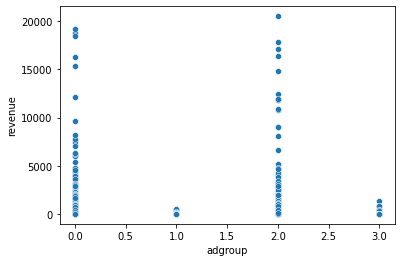

In [18]:
sns.scatterplot(df['adgroup'],df['revenue'])

In [19]:
pd.DataFrame({'revenue':yf['Label']}).to_csv("submission3.csv")

NameError: name 'yf' is not defined

In [ ]:
sns.heatmap(df.corr(),cmap="YlGnBu")